In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/Carpov/Data_set/

/content/drive/MyDrive/Colab Notebooks/Carpov/Data_set


In [4]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here
pipe_lr = Pipeline([('lr_skaler', MinMaxScaler()),
                    ('lr_estimator', LogisticRegression())])

pipe_svm = Pipeline([('lr_skaler', MinMaxScaler()),
                     ('svm_estimator', LinearSVC())])
pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
print(pipe_lr.score(X_test, y_test), pipe_svm.score(X_test, y_test))


0.8426910091284232 0.84039848276437


In [ ]:
### Обучаем модели на трейне
### Your code is here




Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`.

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

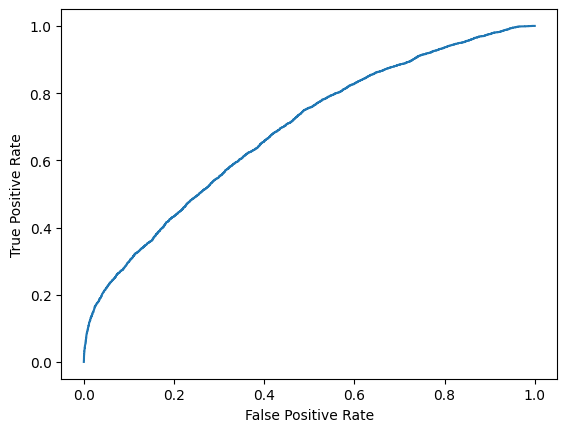

In [10]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
preds_lr = pipe_lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr,thres_lr = roc_curve(y_test, preds_lr)
roc_display_lr = RocCurveDisplay(fpr = fpr_lr, tpr = tpr_lr).plot()
roc_display_lr

In [19]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here
decision_preds = pipe_svm.decision_function(X_test)
min_pred = min(decision_preds)
max_pred = max(decision_preds)

preds_svm = [abs((x-min_pred)/min_pred)*0.5
             if x<=0
             else abs(x/max_pred)*0.5 + 0.5
             for x in decision_preds]



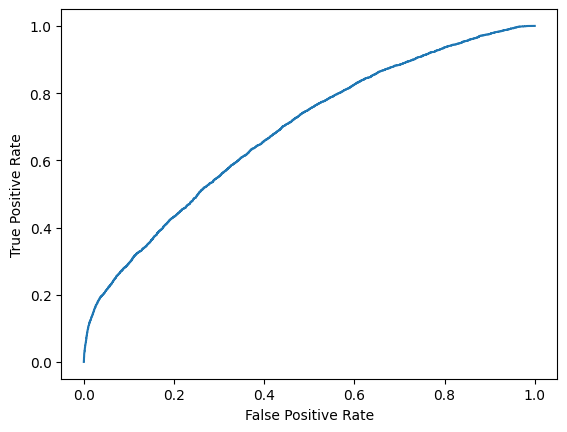

In [20]:
fpr_svm, tpr_svm, thres_svm = roc_curve(y_test, preds_svm)
roc_display_svm = RocCurveDisplay(fpr = fpr_svm, tpr = tpr_svm).plot()
roc_display_svm

In [22]:
from sklearn.metrics import auc

### Your code is here
print(f"LogReg auc: \t {auc(fpr_lr,tpr_lr).round(3)}")
print(f"SVM auc: \t{auc(fpr_svm, tpr_svm).round(3)}")



LogReg auc: 	 0.689
SVM auc: 	0.688


Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

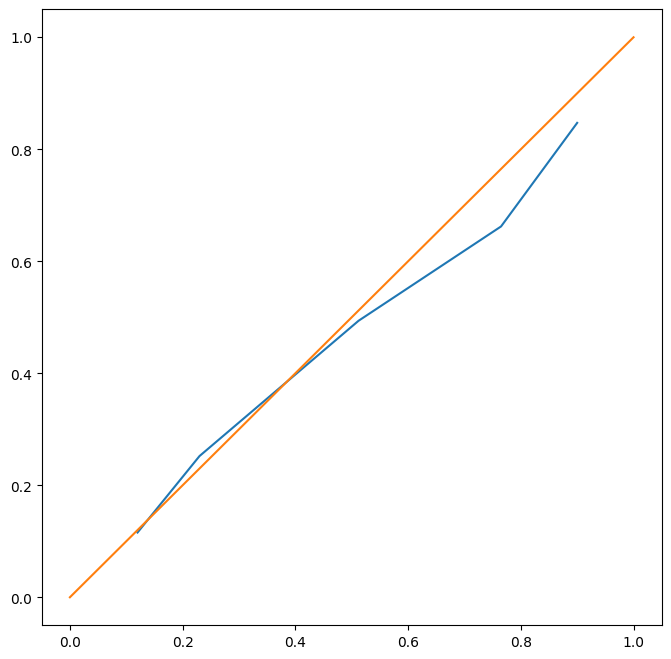

In [25]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
prob_true_lr, prob_pred_lr = calibration_curve(y_test,
                                               preds_lr,
                                               n_bins = 5)
fig = plt.figure()
fig.set_size_inches(8,8)

plt.plot(prob_true_lr, prob_pred_lr)
plt.plot(np.linspace(0,1,5), np.linspace(0,1,5))

plt.show()



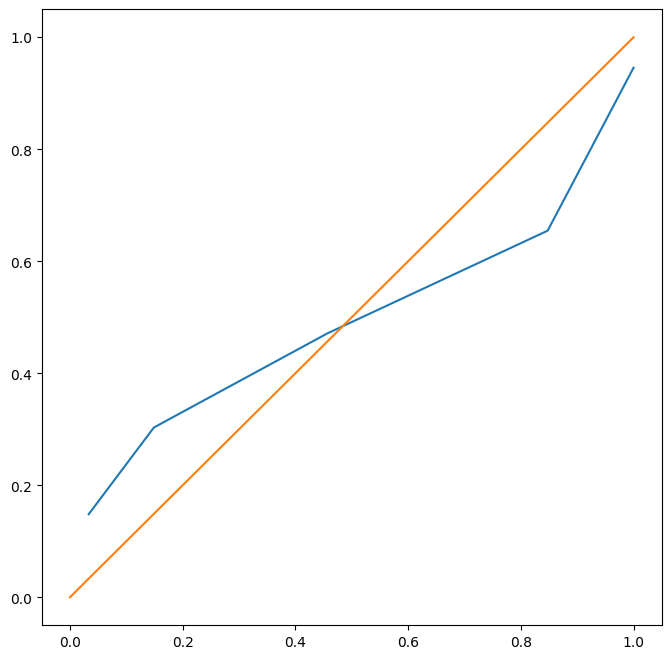

In [27]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
prob_true_svm, prob_pred_svm = calibration_curve(y_test,
                                                 preds_svm,
                                                 n_bins = 5)
fig = plt.figure()
fig.set_size_inches(8,8)

plt.plot(prob_true_svm, prob_pred_svm)
plt.plot(np.linspace(0,1,5), np.linspace(0,1,5))
plt.show()



**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [31]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here
plats_calibration = CalibratedClassifierCV(pipe_svm,
                                           cv = 3,
                                           method = 'isotonic').fit(X_train, y_train)

plats_calibration_preds = plats_calibration.predict_proba(X_test)[:,1]



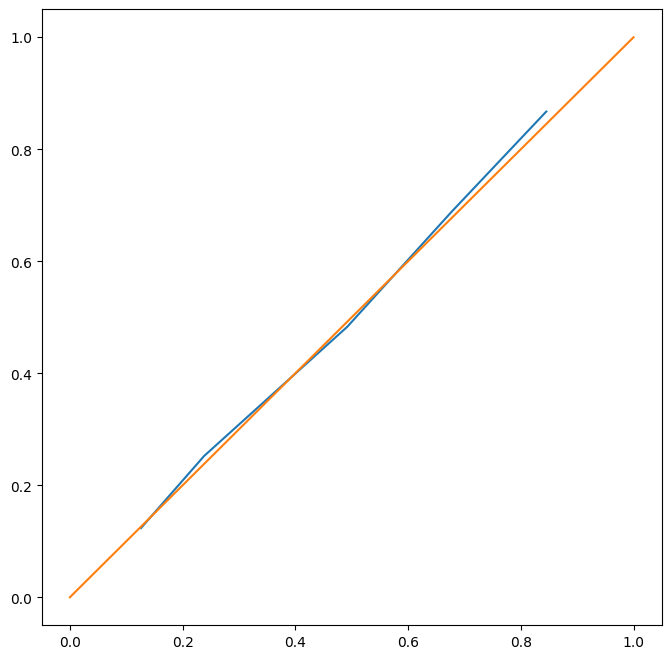

In [32]:
### Новая кривая

### Your code is here

pred_true_svm, pred_proba_svm = calibration_curve(y_test,
                                                  plats_calibration_preds,
                                                  n_bins = 5)
fig = plt.figure()
fig.set_size_inches(8,8)

plt.plot(pred_true_svm, pred_proba_svm)
plt.plot(np.linspace(0,1,5), np.linspace(0,1,5))

plt.show()

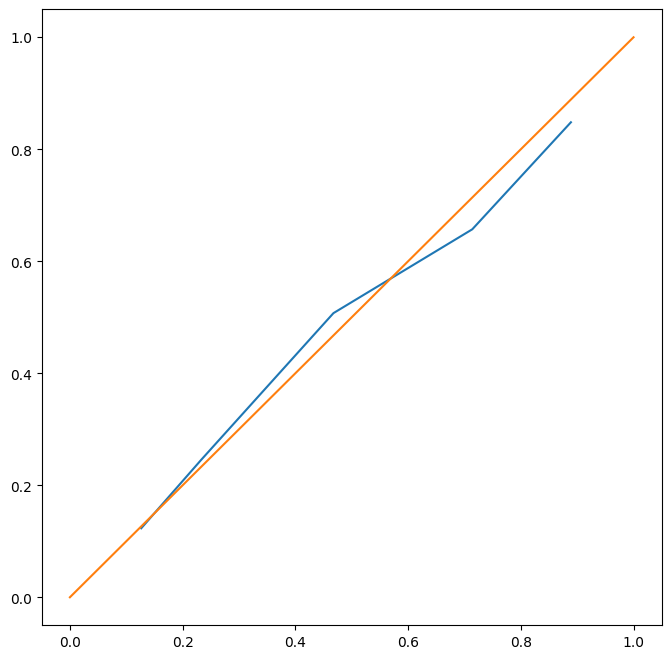

In [30]:
### Новая кривая

### Your code is here

pred_true_svm, pred_proba_svm = calibration_curve(y_test,
                                                  plats_calibration_preds,
                                                  n_bins = 5)
fig = plt.figure()
fig.set_size_inches(8,8)

plt.plot(pred_true_svm, pred_proba_svm)
plt.plot(np.linspace(0,1,5), np.linspace(0,1,5))

plt.show()


